In [331]:
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

from IPython.display import clear_output
from datetime import datetime

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, train_test_split

%matplotlib inline
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.5)
sns.set_style('ticks')

from os import listdir
from os.path import isfile, join
import os
#os.getcwd()
os.chdir('/Users/Grant/Documents/Model Risk Mgmt/MRM-Project')
import warnings
warnings.filterwarnings('ignore')


In [332]:
os.getcwd()
#os.chdir('/Users/Grant/Documents/Model Risk Mgmt/MRM-Project')

'/Users/Grant/Documents/Model Risk Mgmt/MRM-Project'

In [7]:
# Save model dataframe to a pickle file for easier reading
#model_df.to_pickle('model_df.pkl')
model_df = pd.read_pickle('model_df.pkl')

In [313]:
model_df.fully_paid.value_counts()

1    112445
0     28465
Name: fully_paid, dtype: int64

## Using Optuna to find optimal parameters. Focusing on having models with high accuracy and high recall and we will have to find the balance that works best for us

In [317]:
import optuna
import lightgbm as lgb
import sklearn.metrics
from sklearn.model_selection import train_test_split

# FYI: Objective functions can take additional arguments
# (https://optuna.readthedocs.io/en/stable/faq.html#objective-func-additional-args).
def objective(trial):
    data, target = X,y
    train_x, valid_x, train_y, valid_y = train_test_split(data, target, test_size=0.25, stratify=target, random_state=42)
    dtrain = lgb.Dataset(train_x, label=train_y)

    param = {
        "objective": "binary",
        "metric": "binary_logloss",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }
    
    gbm = lgb.train(param, dtrain)
    preds = gbm.predict(valid_x)
    pred_labels = np.rint(preds)
    accuracy = sklearn.metrics.accuracy_score(valid_y, pred_labels)
    #recall = sklearn.metrics.recall_score(valid_y, pred_labels)
    return accuracy#, recall

# Dropping a ton of columns that didn't really help the model. Call X.columns for final list of features used

In [341]:
X = model_df.drop(columns = ['term','term_ 60 months','emp_length','fico_range_high','fico_range_low','home_ownership','sec_app_fico_range_high',
'sec_app_fico_range_low','grade','sub_grade','fully_paid','installment','int_rate','zip_code','issue_d',
'year','last_fico_range_high','last_fico_range_low','purpose_credit_card','purpose_debt_consolidation',
'purpose_educational','purpose_home_improvement','purpose','application_type_Joint App',
'verification_status_Source Verified','verification_status','addr_state','application_type','pub_rec','tax_liens',
'pub_rec_bankruptcies','num_op_rev_tl','num_sats','total_bal_ex_mort','mo_sin_rcnt_rev_tl_op',
'mths_since_recent_revol_delinq','tot_coll_amt','pct_tl_nvr_dlq','num_rev_accts','num_bc_tl','inq_last_6mths',
'num_bc_sats','open_acc','emp_length_10+ years','emp_length_2-4 years', 'emp_length_5-9 years','purpose_house', 
'purpose_major_purchase', 'purpose_medical','purpose_moving', 'purpose_other', 'purpose_renewable_energy',
'purpose_small_business', 'purpose_vacation', 'purpose_wedding','acc_now_delinq','num_accts_ever_120_pd','delinq_2yrs','chargeoff_within_12_mths',
'collections_12_mths_ex_med','delinq_amnt','mo_sin_old_il_acct','home_ownership_MORTGAGE',
'home_ownership_NONE', 'home_ownership_OTHER', 'home_ownership_OWN','home_ownership_RENT'])
y = model_df['fully_paid']

In [342]:
X.columns

Index(['acc_open_past_24mths', 'annual_inc', 'avg_cur_bal', 'bc_open_to_buy',
       'bc_util', 'dti', 'loan_amnt', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_tl',
       'mort_acc', 'mths_since_last_delinq', 'mths_since_last_major_derog',
       'mths_since_last_record', 'mths_since_recent_bc',
       'mths_since_recent_bc_dlq', 'mths_since_recent_inq', 'num_actv_bc_tl',
       'num_actv_rev_tl', 'num_il_tl', 'num_rev_tl_bal_gt_0',
       'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'percent_bc_gt_75',
       'revol_bal', 'revol_util', 'tot_cur_bal', 'tot_hi_cred_lim',
       'total_acc', 'total_bc_limit', 'total_il_high_credit_limit',
       'total_rev_hi_lim', 'credit_line_age', 'verification_status_Verified',
       'month'],
      dtype='object')

In [320]:
study = optuna.create_study(directions=['maximize'])
study.optimize(objective, n_trials=100)

[I 2024-11-21 18:19:13,760] A new study created in memory with name: no-name-ac82a5ee-88f6-47fd-a63a-d5abb9bb7191
[I 2024-11-21 18:19:20,310] Trial 0 finished with value: 0.7957306687861928 and parameters: {'lambda_l1': 0.036938600467326034, 'lambda_l2': 6.852433997112969e-08, 'num_leaves': 209, 'feature_fraction': 0.6727899715436705, 'bagging_fraction': 0.6080707632065864, 'bagging_freq': 2, 'min_child_samples': 94}. Best is trial 0 with value: 0.7957306687861928.
[I 2024-11-21 18:19:22,292] Trial 1 finished with value: 0.7974338594299989 and parameters: {'lambda_l1': 3.8092097716696385e-07, 'lambda_l2': 4.083691201401012e-08, 'num_leaves': 54, 'feature_fraction': 0.47644767687087025, 'bagging_fraction': 0.4443865931022313, 'bagging_freq': 2, 'min_child_samples': 57}. Best is trial 1 with value: 0.7974338594299989.
[I 2024-11-21 18:19:22,933] Trial 2 finished with value: 0.7980015896446009 and parameters: {'lambda_l1': 3.5014024600581233, 'lambda_l2': 1.6331034369879678e-07, 'num_leav

In [322]:
study.best_trial

FrozenTrial(number=74, state=TrialState.COMPLETE, values=[0.7998183263313273], datetime_start=datetime.datetime(2024, 11, 21, 18, 20, 47, 852859), datetime_complete=datetime.datetime(2024, 11, 21, 18, 20, 48, 660548), params={'lambda_l1': 1.598937213161827e-08, 'lambda_l2': 8.601525263703759e-05, 'num_leaves': 28, 'feature_fraction': 0.4199173047742936, 'bagging_fraction': 0.6383454175289989, 'bagging_freq': 7, 'min_child_samples': 45}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'lambda_l1': FloatDistribution(high=10.0, log=True, low=1e-08, step=None), 'lambda_l2': FloatDistribution(high=10.0, log=True, low=1e-08, step=None), 'num_leaves': IntDistribution(high=256, log=False, low=2, step=1), 'feature_fraction': FloatDistribution(high=1.0, log=False, low=0.4, step=None), 'bagging_fraction': FloatDistribution(high=1.0, log=False, low=0.4, step=None), 'bagging_freq': IntDistribution(high=7, log=False, low=1, step=1), 'min_child_samples': IntDistribution(high=10

In [323]:
trialbst = optuna.trial.Trial(study,74)
trialbst.params

{'lambda_l1': 1.598937213161827e-08,
 'lambda_l2': 8.601525263703759e-05,
 'num_leaves': 28,
 'feature_fraction': 0.4199173047742936,
 'bagging_fraction': 0.6383454175289989,
 'bagging_freq': 7,
 'min_child_samples': 45}

In [343]:
# Splitting into train/test splits and stratifying the target
X_train, X_test, y_train, y_test = train_test_split(
    X,y, test_size=0.25, random_state=4, stratify=y)

### These params were found from a previous study, but they worked well. First model below shows pretty strong overfitting, suggesting we go with this one to be one of our flaws. Second model performs better and minimizes changes in train/test accuracy(better fitting model): this should be the "correct" model. Maybe make this flaw be the undocumented flaw? Have FICO being in the model should be the documented flaw. So leave FICO in the model, have it not be included in the datadict

Training accuracy 0.8029
Testing accuracy 0.7989


<AxesSubplot:title={'center':'Metric during training'}, xlabel='Iterations', ylabel='binary_logloss'>

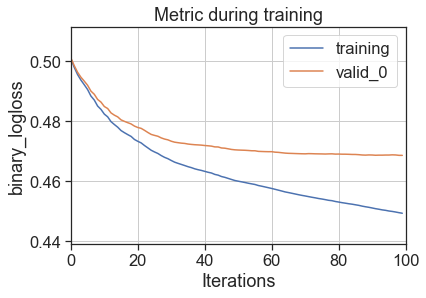

In [345]:
lgbm = lgb.LGBMClassifier(lambda_l1= 1.598937213161827e-08,
    lambda_l2= 8.601525263703759e-05,
    num_leaves= 28,
    feature_fraction= 0.4199173047742936,
    bagging_fraction= 0.6383454175289989,
    bagging_freq= 7,
    min_child_samples= 45)
lgbm.fit(X_train, y_train, eval_set=[(X_test,y_test),(X_train,y_train)])
print('Training accuracy {:.4f}'.format(lgbm.score(X_train,y_train)))
print('Testing accuracy {:.4f}'.format(lgbm.score(X_test,y_test)))
lgb.plot_metric(lgbm)

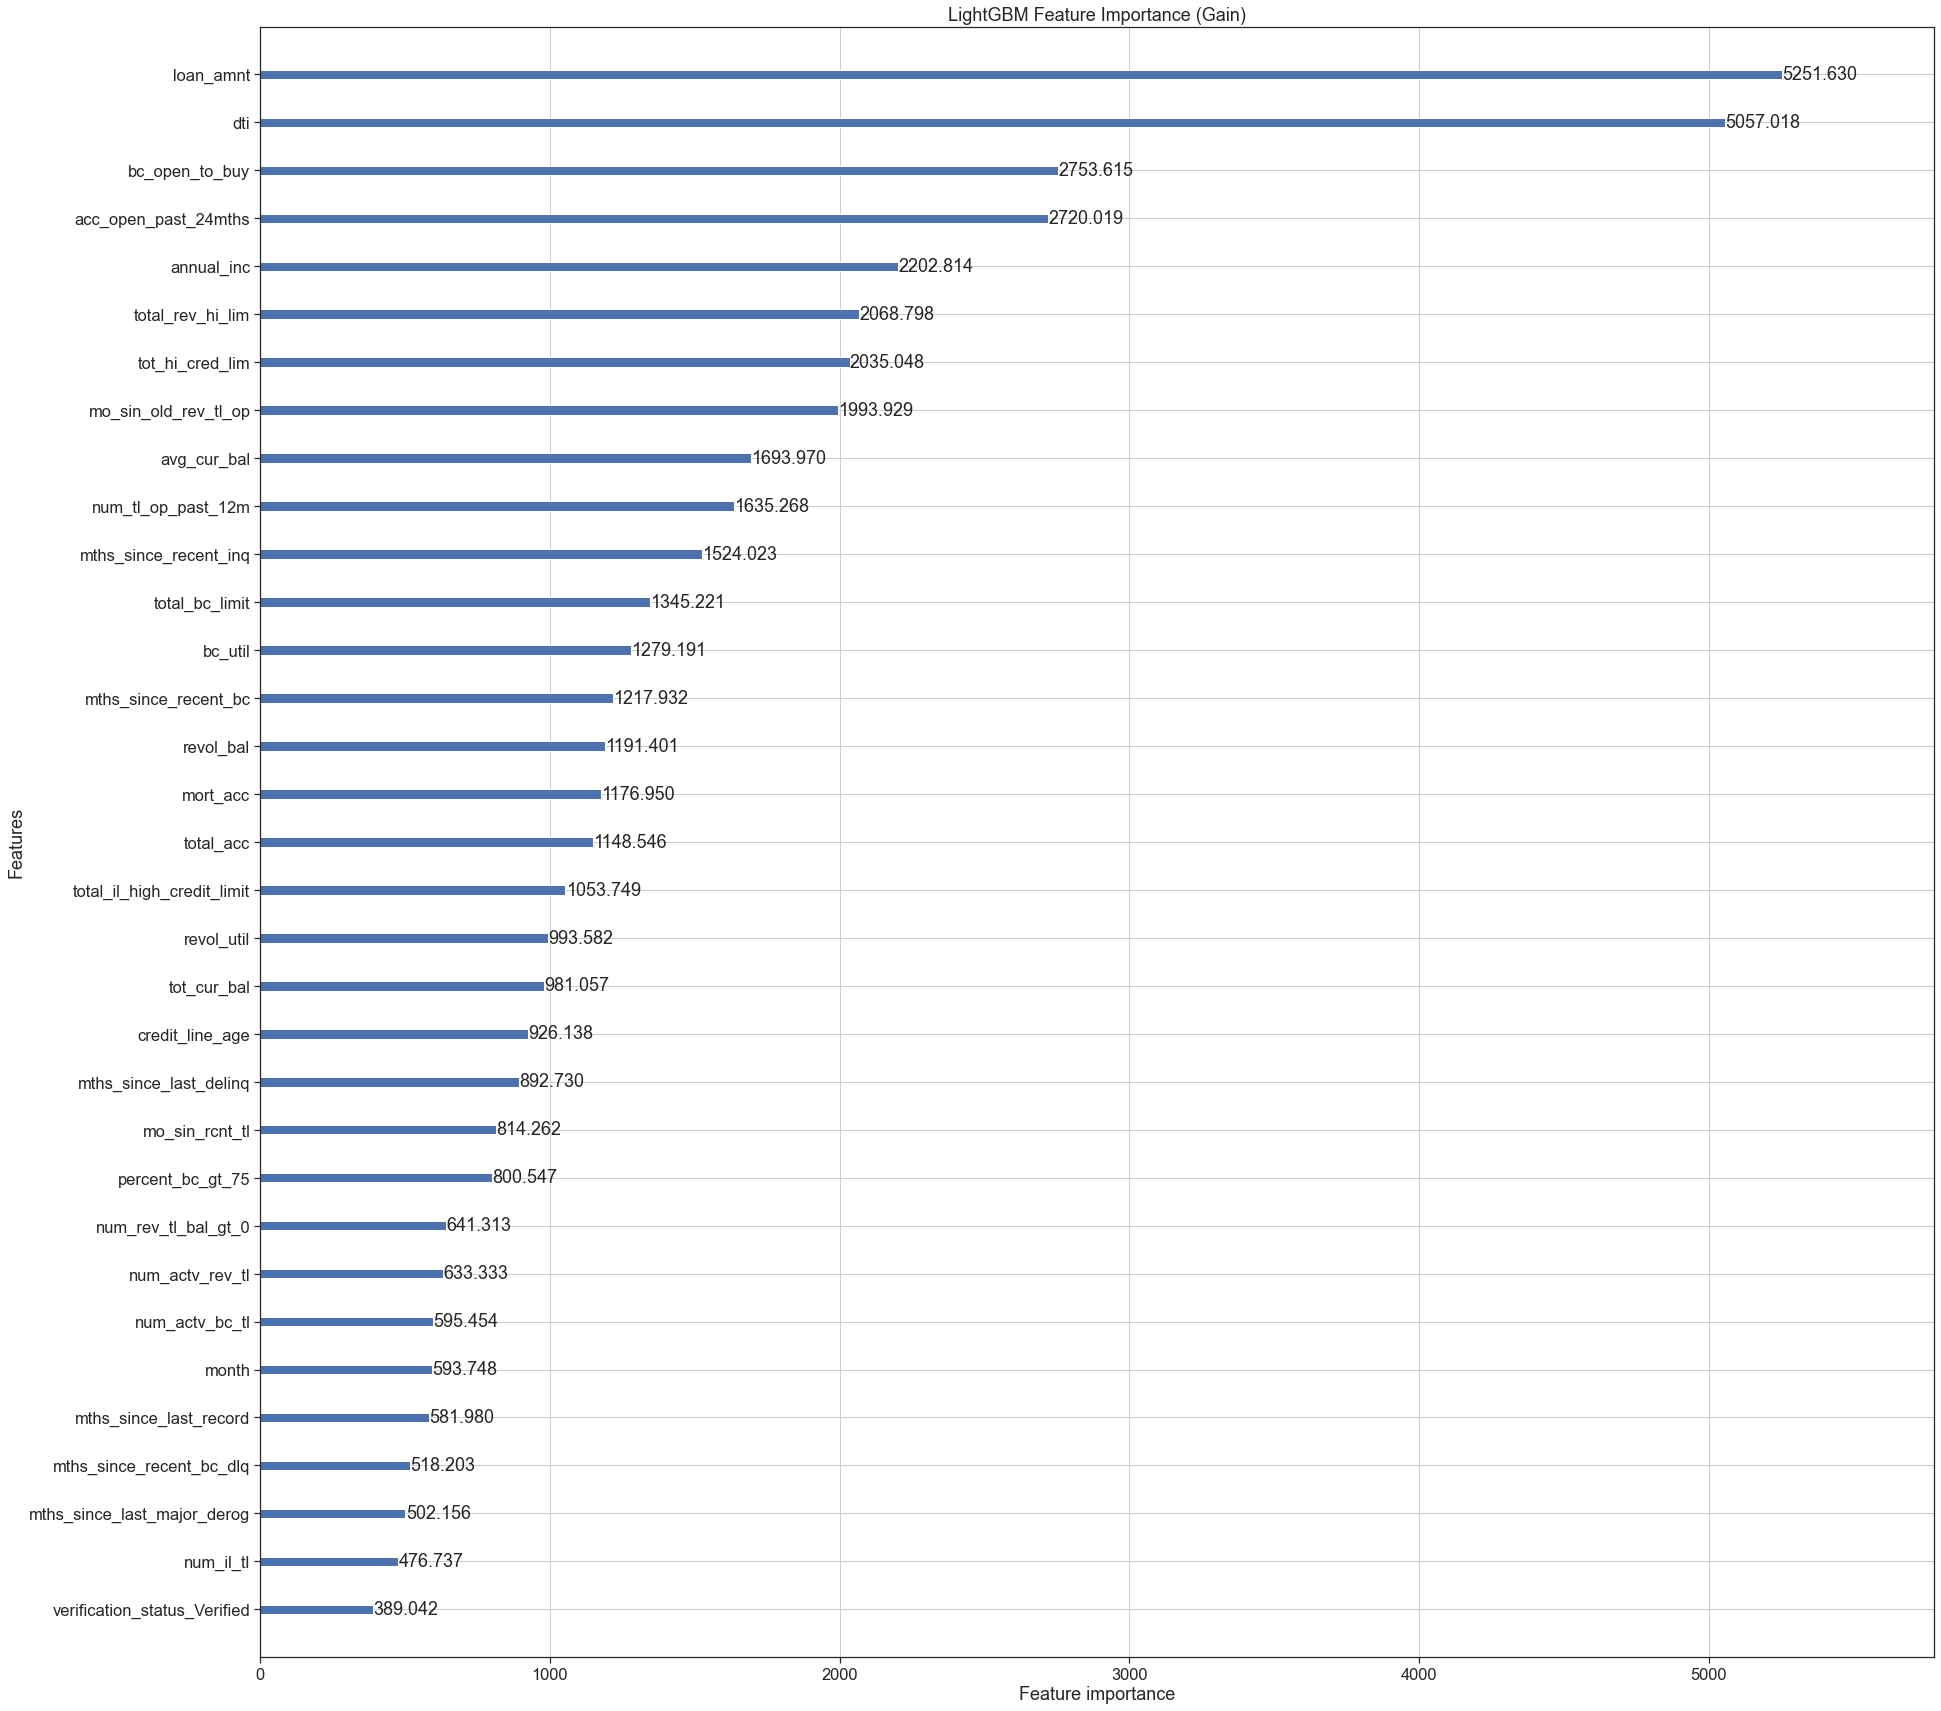

In [346]:
# Feature importance for first model
lgb.plot_importance(lgbm, importance_type="gain", figsize=(30,30), title="LightGBM Feature Importance (Gain)")
plt.show()

In [347]:
features = X_test.columns
importances = lgbm.feature_importances_
feature_importance = pd.DataFrame({'importance':importances,'features':features}).sort_values('importance', ascending=False).reset_index(drop=True)
feature_importance

,importance,features
0,157,dti
1,151,loan_amnt
2,131,mo_sin_old_rev_tl_op
3,123,annual_inc
4,116,total_rev_hi_lim
5,113,bc_open_to_buy
6,112,revol_bal
7,111,tot_hi_cred_lim
8,110,avg_cur_bal
9,101,bc_util


Training accuracy 0.8000
Testing accuracy 0.7991


<AxesSubplot:title={'center':'Metric during training'}, xlabel='Iterations', ylabel='binary_logloss'>

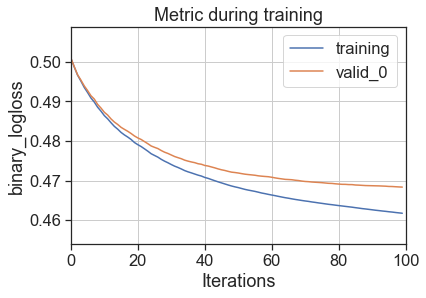

In [348]:
# Second model with params from a previous study and using same eval metrics as before
lgbm2 = lgb.LGBMClassifier(lambda_l1= 2.223364546834443,
    lambda_l2= 1.649432904280486,
    num_leaves= 11,
    feature_fraction= 0.5306603476323929,
    bagging_fraction= 0.8729028811929775,
    bagging_freq= 2,
    min_child_samples= 69)
lgbm2.fit(X_train, y_train, eval_set=[(X_test,y_test),(X_train,y_train)])
print('Training accuracy {:.4f}'.format(lgbm2.score(X_train,y_train)))
print('Testing accuracy {:.4f}'.format(lgbm2.score(X_test,y_test)))
lgb.plot_metric(lgbm2)

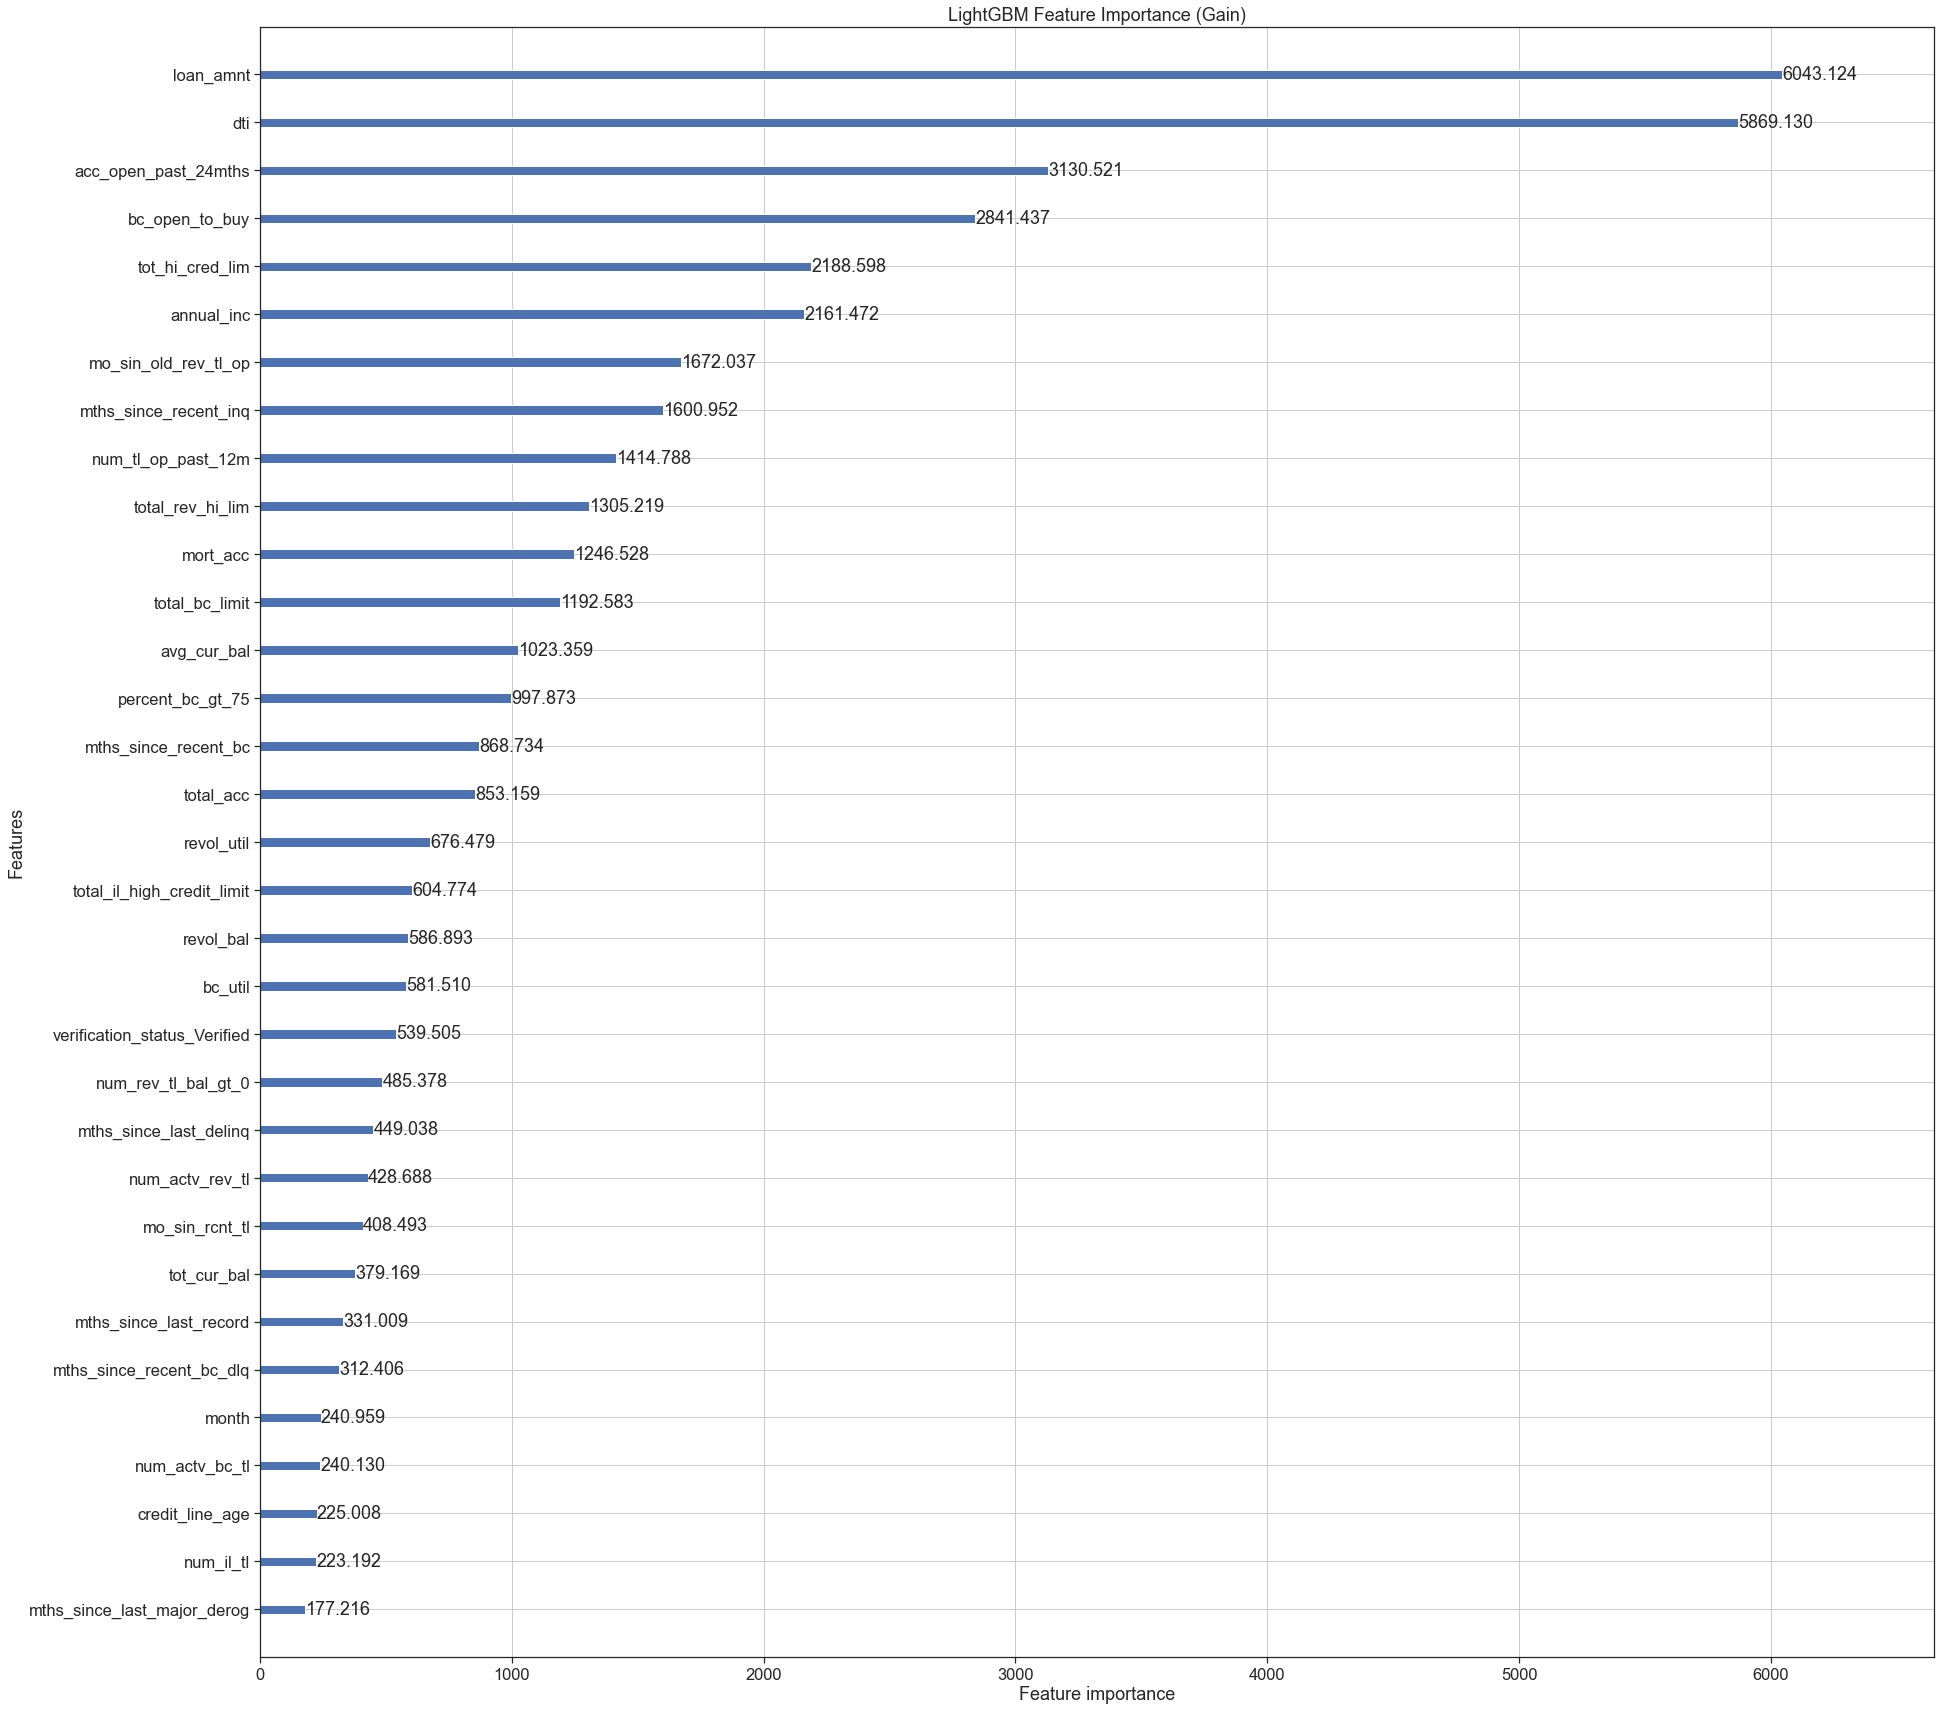

In [349]:
# Feature importance for second LGBM
lgb.plot_importance(lgbm2, importance_type="gain", figsize=(30,30), title="LightGBM Feature Importance (Gain)")
plt.show()

In [350]:
features = X_test.columns
importances = lgbm2.feature_importances_
feature_importance = pd.DataFrame({'importance':importances,'features':features}).sort_values('importance', ascending=False).reset_index(drop=True)
feature_importance

,importance,features
0,111,loan_amnt
1,72,dti
2,58,annual_inc
3,54,acc_open_past_24mths
4,50,mo_sin_old_rev_tl_op
5,39,total_acc
6,39,bc_open_to_buy
7,38,total_rev_hi_lim
8,38,tot_hi_cred_lim
9,37,mths_since_recent_inq


## Partial Dependency Plots

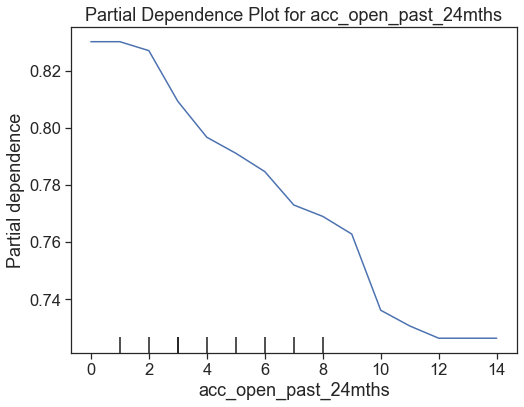

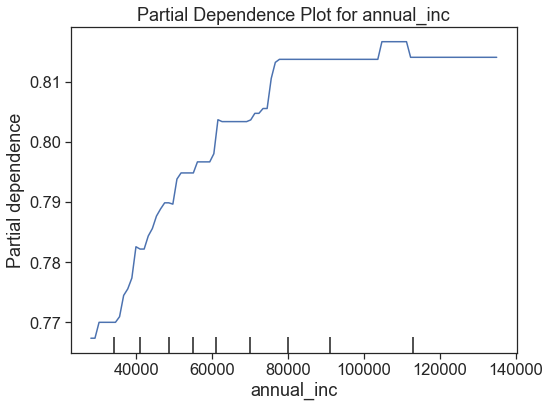

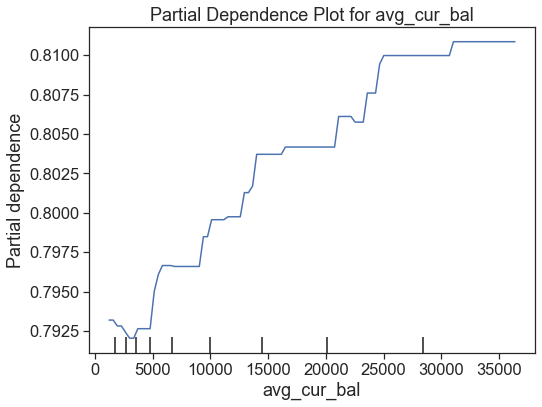

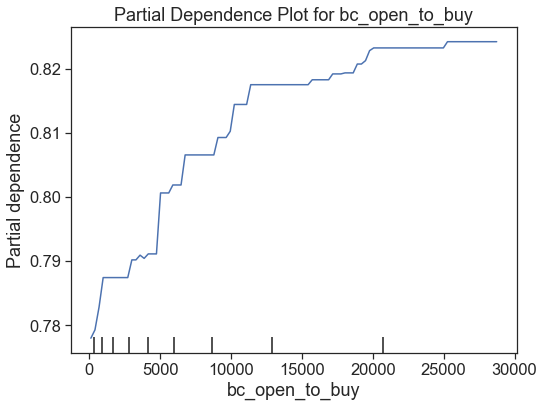

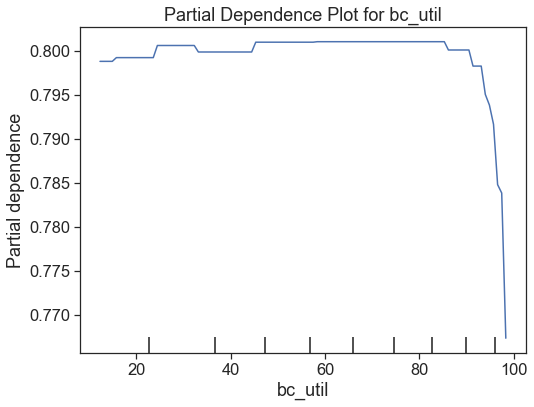

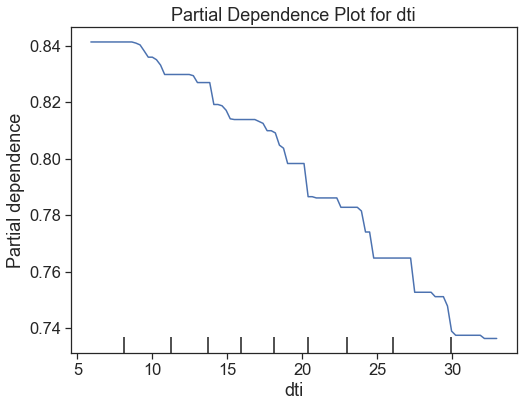

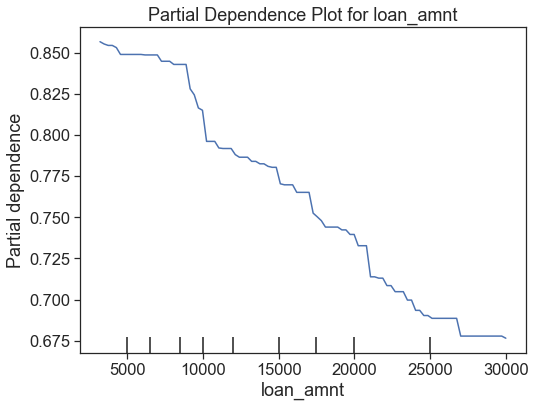

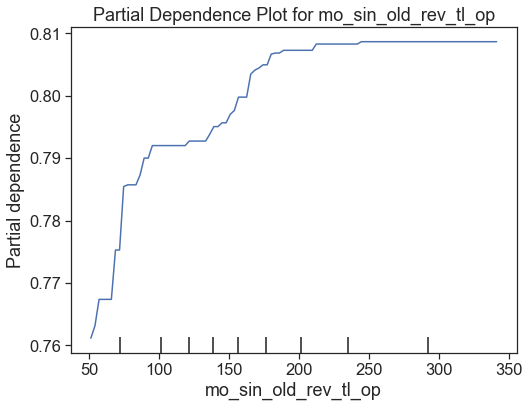

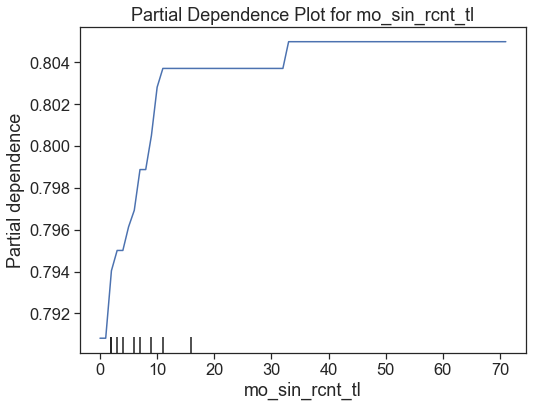

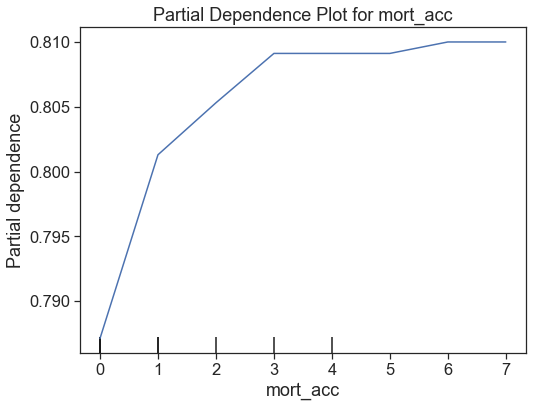

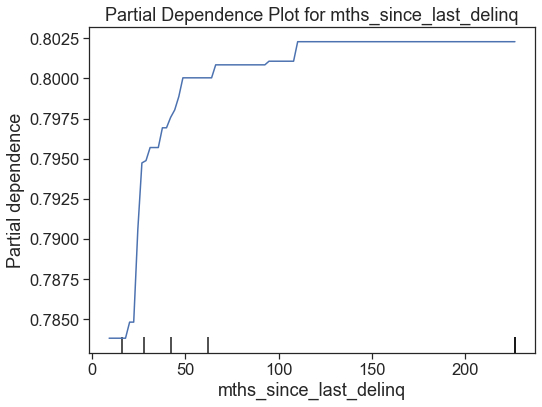

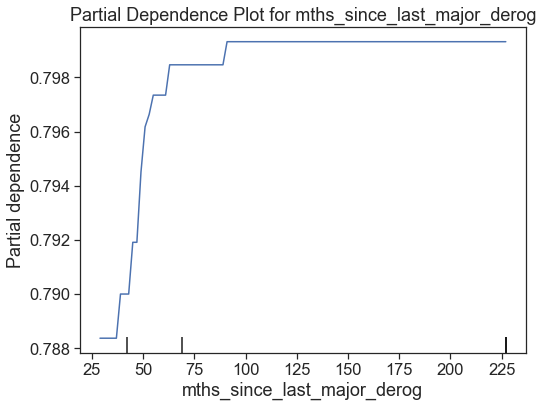

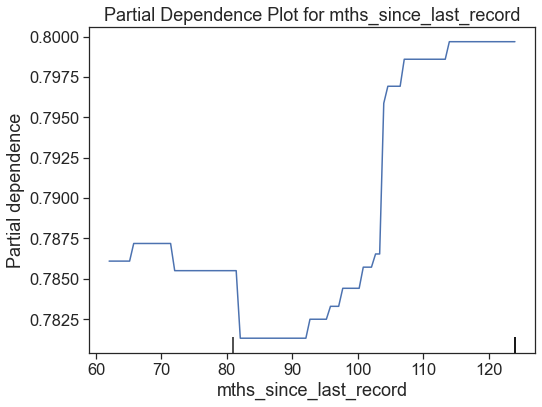

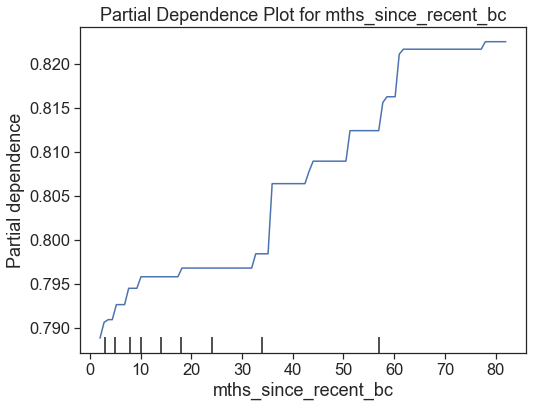

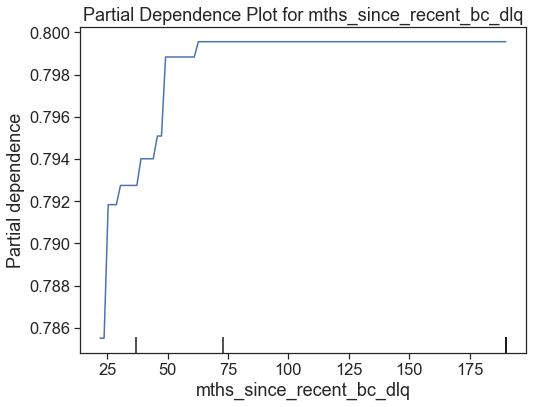

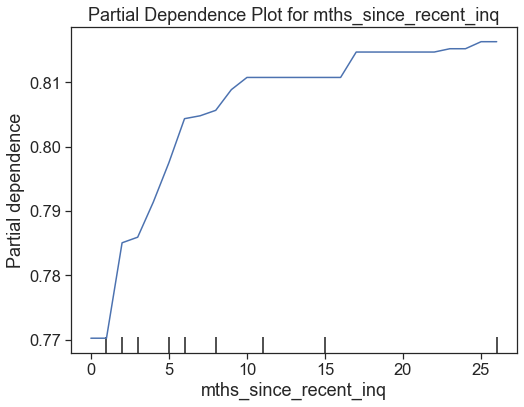

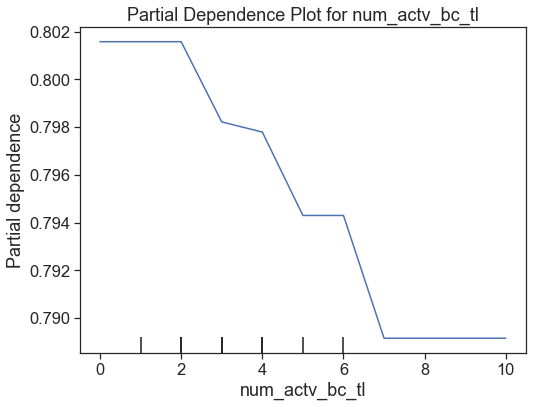

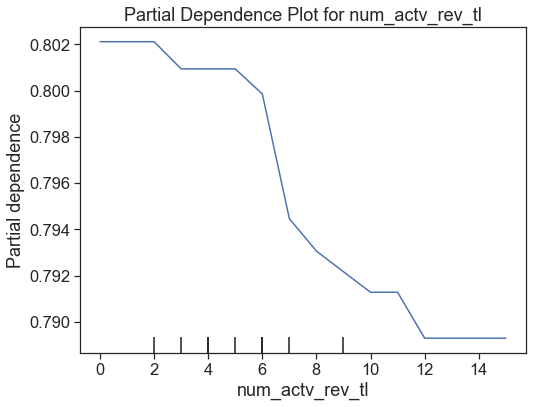

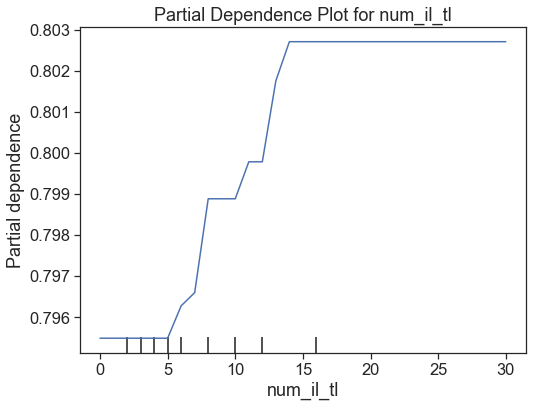

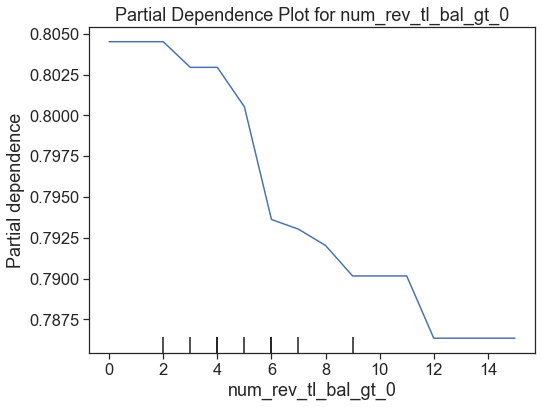

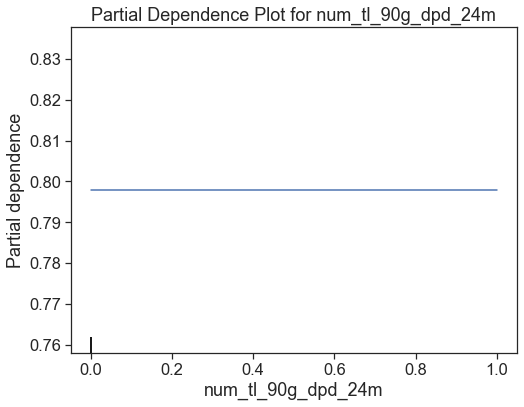

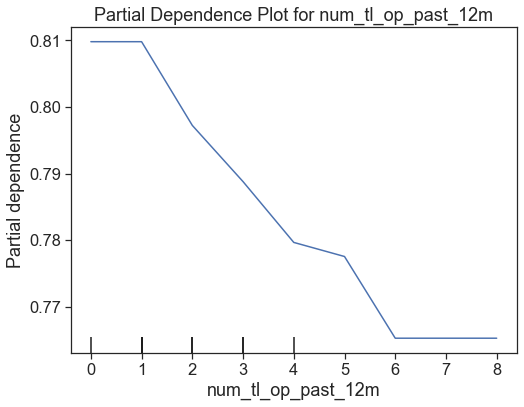

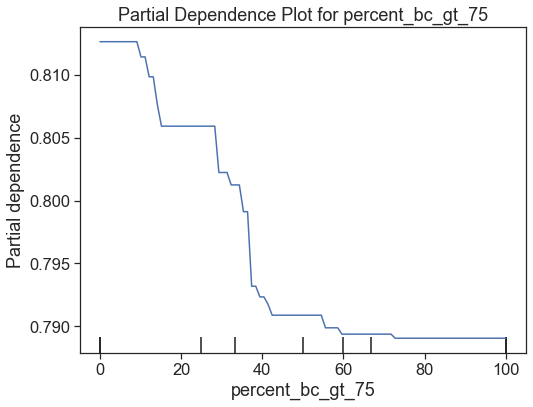

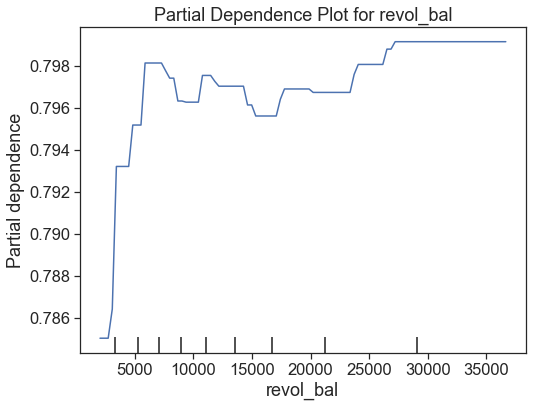

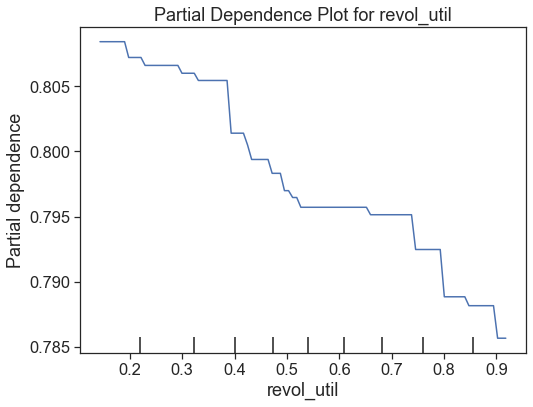

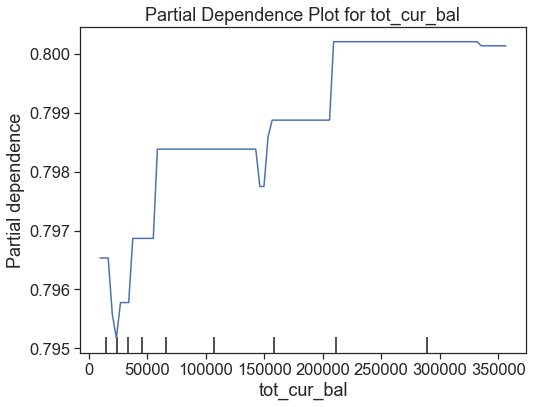

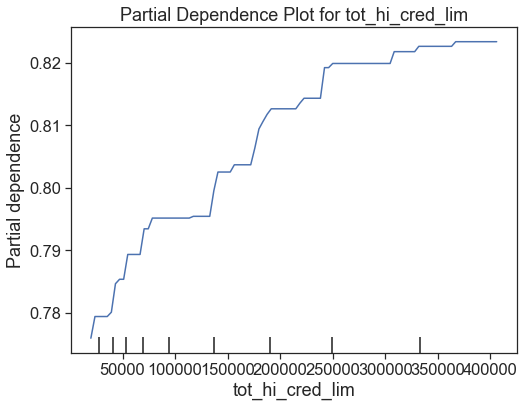

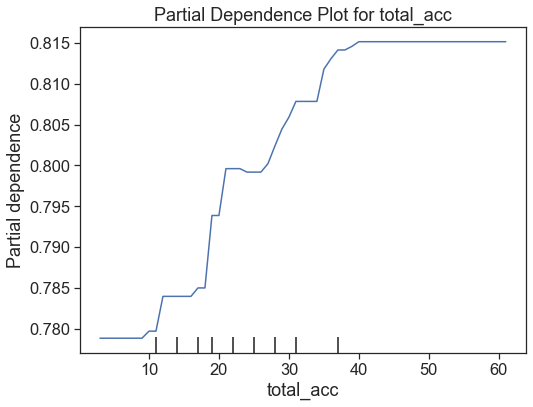

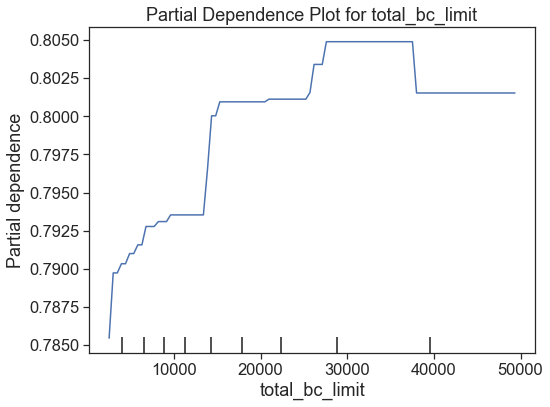

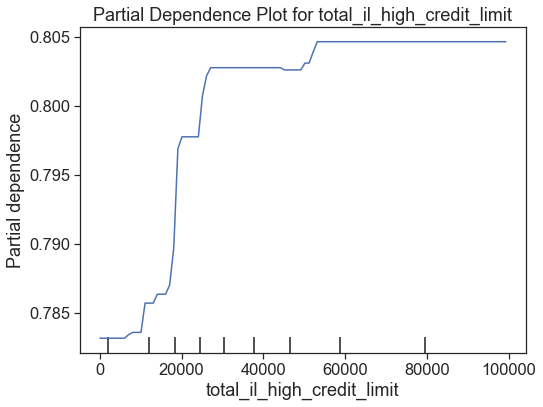

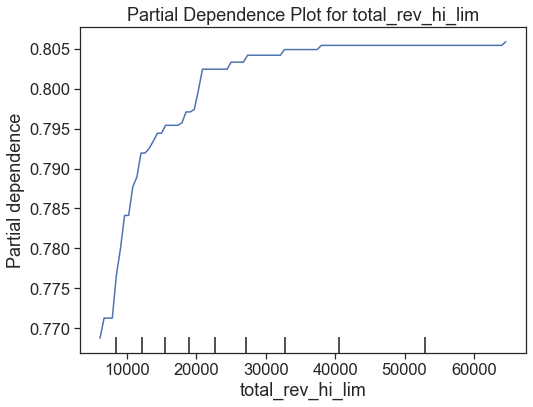

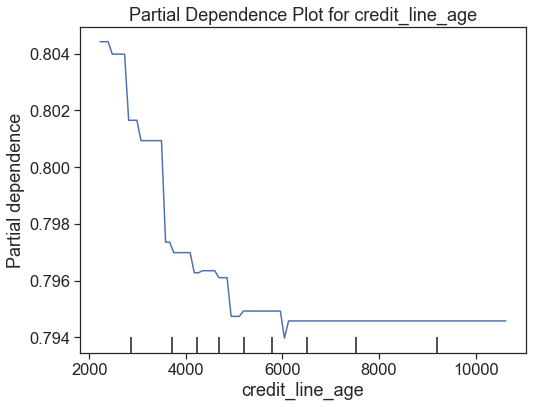

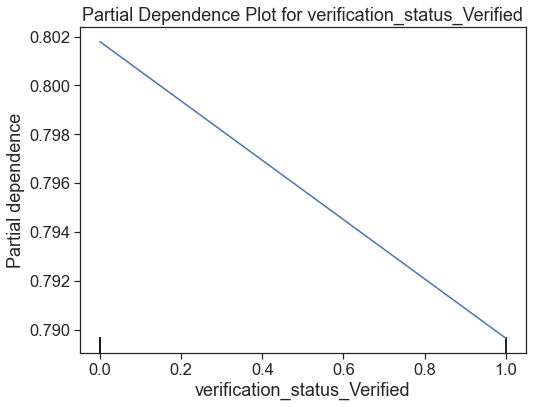

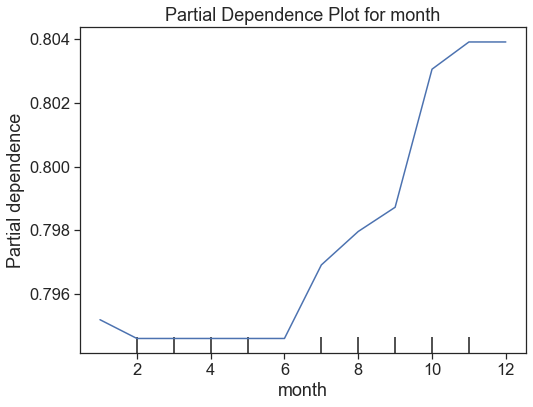

In [351]:
from sklearn.inspection import PartialDependenceDisplay
for feature in X.columns:
    plt.figure(figsize=(8, 6))
    PartialDependenceDisplay.from_estimator(
        estimator=lgbm2,
        X=X_train,
        features=[feature],
        kind="average",  # Change to 'both' to include ICE curves
        ax=plt.gca(),
    )
    plt.title(f"Partial Dependence Plot for {feature}")
    plt.show()